# Training Object Detection

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss, MSELoss, Dropout, Identity
from torch.nn import Linear, Module, ReLU, Sequential, Sigmoid
from torch.optim import Adam

from torchvision.models import resnet50
from torchvision import transforms

from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle,torch, time, mimetypes, imutils, cv2, os

import matplotlib
matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
%matplotlib inline

## Config Model

In [22]:
class Config:
    BASE_PATH = r'D:\Estudos\PyImageSearch\PyTorch 103 - Advanced PyTorch Techniques'

    IMAGES_PATH = BASE_PATH + "\\dataset\\images"
    ANNOTS_PATH = BASE_PATH + "\\dataset\\annotations"

    BASE_OUTPUT = BASE_PATH + "\\output"

    MODEL_PATH = BASE_OUTPUT + "\\detector.pth"
    LE_PATH = BASE_OUTPUT + "\\le.pickle"
    PLOTS_PATH = BASE_OUTPUT + "\\plots"
    TEST_PATHS = BASE_OUTPUT + "\\test_paths.txt"

    ## Config CUDA
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    PIN_MEMORY = True if DEVICE == 'cuda' else False

    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    INIT_LR = 1e-4
    NUM_EPOCHS = 20
    BATCH_SIZE = 32

    LABELS = 1.0
    BBOX = 1.0

config = Config()

## Create Data Pipeline

[INFO] | Loading datasets ...
[INFO] | Loading ends ...


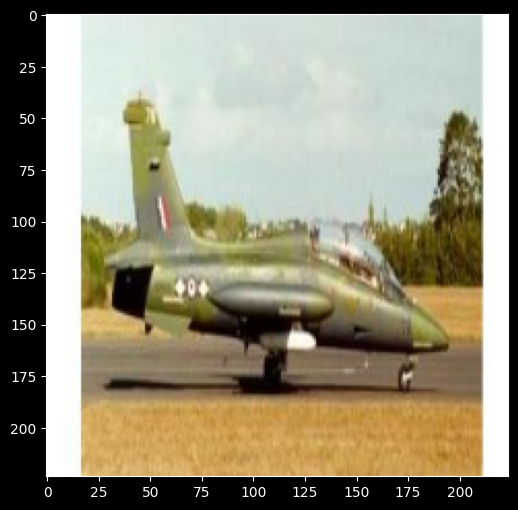

In [23]:
print("[INFO] | Loading datasets ...")
data = []
labels = []
bboxes = []
imagePaths = []

for csvPath in paths.list_files(config.ANNOTS_PATH, validExts=(".csv")):
    rows = open(csvPath).read().strip().split("\n")

    for row in rows:
        row = row.split(',')
        filename, startX, startY, endX, endY, label = row

        imagePath = os.path.sep.join([config.IMAGES_PATH, label, filename])
        #print(imagePath)
        image = cv2.imread(imagePath)
        h, w = image.shape[:2]

        #Dimensions
        startX = float(startX)/w
        startY = float(startY)/h

        endX = float(endX)/w
        endY = float(endY)/h

        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)
print("[INFO] | Loading ends ...")

plt.imshow(data[0])
plt.show()

## Custom Tensor Dataset

In [24]:
class CustomTensorDataset(Dataset):
    # initialize the constructor
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms

    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]

        # transpose the image such that its channel dimension becomes
        # the leading one
        image = image.permute(2, 0, 1)

        # check to see if we have any image transformations to apply
        # and if so, apply them
        if self.transforms:
            image = self.transforms(image)

        # return a tuple of the images, labels, and bounding
        # box coordinates
        return (image, label, bbox)

    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)

## Convert data in Tensor

In [25]:
data = np.array(data, dtype = "float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype = "float32")
imagePaths = np.array(imagePaths)

In [26]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [27]:
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.2, random_state=42)

In [28]:
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [29]:
# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages), torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),  torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes), torch.tensor(testBBoxes)

In [30]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])

In [31]:
# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes), transforms=transform)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes), transforms=transform)

print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))


[INFO] total training samples: 1626...
[INFO] total test samples: 407...


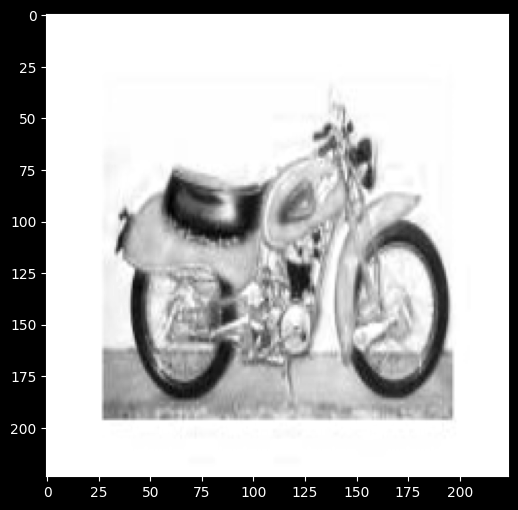

In [32]:
plt.imshow(trainImages[0][:,:,::3]);

In [33]:
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(testDS) // config.BATCH_SIZE

In [56]:
# create data loaders
trainLoader = DataLoader(trainDS, batch_size=config.BATCH_SIZE,
                         shuffle=True)

testLoader = DataLoader(testDS, batch_size=config.BATCH_SIZE)


In [57]:
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

In [58]:
os.cpu_count()

20

## Building the Object Detector

In [59]:
class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()

        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses

        # build the regressor head for outputting the bounding box
        # coordinates
        self.regressor = Sequential(
            Linear(baseModel.fc.in_features, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4),
            Sigmoid()
        )

        # build the classifier head to predict the class labels
        self.classifier = Sequential(
            Linear(baseModel.fc.in_features, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses)
        )

        # set the classifier of our base model to produce outputs
        # from the last convolution block
        self.baseModel.fc = Identity()

    def forward(self, x):
        # pass the inputs through the base model and then obtain
        # predictions from two different branches of the network
        features = self.baseModel(x)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)

        # return the outputs as a tuple
        return (bboxes, classLogits)

In [60]:
# load the ResNet50 network
resnet = resnet50(pretrained=True)

# freeze all ResNet50 layers
for param in resnet.parameters():
    param.requires_grad = False

In [61]:
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(config.DEVICE)

classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
opt = Adam(objectDetector.parameters(), lr=config.INIT_LR)
print(objectDetector)

# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
     "val_class_acc": []}

ObjectDetector(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

## Training Model

In [62]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    objectDetector.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    for (images, labels, bboxes) in trainLoader:
        # send the input to the device
        (images, labels, bboxes) = (images.to(config.DEVICE),
                                    labels.to(config.DEVICE), bboxes.to(config.DEVICE))

        # perform a forward pass and calculate the training loss
        predictions = objectDetector(images)
        bboxLoss = bboxLossFunc(predictions[0], bboxes)
        classLoss = classLossFunc(predictions[1], labels)
        totalLoss = (config.BBOX * bboxLoss) + (config.LABELS * classLoss)

        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += totalLoss
        trainCorrect += (predictions[1].argmax(1) == labels).type(
            torch.float).sum().item()

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        objectDetector.eval()

        # loop over the validation set
        for (images, labels, bboxes) in testLoader:
            # send the input to the device
            (images, labels, bboxes) = (images.to(config.DEVICE),
                                        labels.to(config.DEVICE), bboxes.to(config.DEVICE))

            # make the predictions and calculate the validation loss
            predictions = objectDetector(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            classLoss = classLossFunc(predictions[1], labels)
            totalLoss = (config.BBOX * bboxLoss) + \
                        (config.LABELS * classLoss)
            totalValLoss += totalLoss

            # calculate the number of correct predictions
            valCorrect += (predictions[1].argmax(1) == labels).type(
                torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(testDS)

    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
endTime = time.time()

print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


  5%|▌         | 1/20 [02:01<38:20, 121.05s/it]

[INFO] EPOCH: 1/20
Train loss: 0.775250, Train accuracy: 0.8186
Val loss: 0.202414, Val accuracy: 0.9975


 10%|█         | 2/20 [04:01<36:14, 120.78s/it]

[INFO] EPOCH: 2/20
Train loss: 0.145886, Train accuracy: 0.9822
Val loss: 0.047701, Val accuracy: 1.0000


 15%|█▌        | 3/20 [06:00<33:55, 119.72s/it]

[INFO] EPOCH: 3/20
Train loss: 0.071615, Train accuracy: 0.9865
Val loss: 0.025621, Val accuracy: 1.0000


 20%|██        | 4/20 [07:59<31:51, 119.48s/it]

[INFO] EPOCH: 4/20
Train loss: 0.047542, Train accuracy: 0.9883
Val loss: 0.014828, Val accuracy: 1.0000


 20%|██        | 4/20 [09:14<36:58, 138.63s/it]


KeyboardInterrupt: 

## Save the model to disk

In [63]:
torch.save(objectDetector, config.MODEL_PATH)

In [64]:
f = open(config.LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()

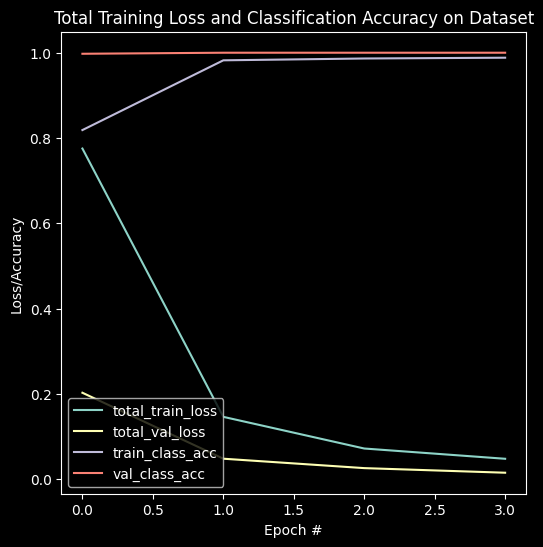

In [65]:
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [66]:
plotPath = os.path.sep.join([config.PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

<Figure size 600x600 with 0 Axes>

## Run Model

In [67]:
args = {
    "input": "dataset/images/airplane/image_0001.jpg"
}

In [68]:
# determine the input
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

if "text/plain" == filetype:
    imagePaths = open(args["input"]).read().strip().split("\n")

In [69]:
# load our object detector
print("[INFO] loading object detector...")
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
model.eval()
le = pickle.loads(open(config.LE_PATH, "rb").read())

[INFO] loading object detector...


In [70]:
# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])

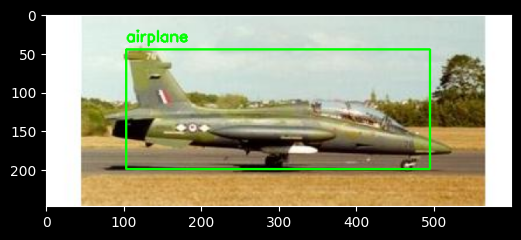

In [71]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    orig = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.transpose((2, 0, 1))

    image = torch.from_numpy(image)
    image = transforms(image).to(config.DEVICE)
    image = image.unsqueeze(0)

    (boxPreds, labelPreds) = model(image)
    (startX, startY, endX, endY) = boxPreds[0]

    labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
    i = labelPreds.argmax(dim=-1).cpu()
    label = le.inverse_transform(i)[0]

    orig = imutils.resize(orig, width=600)
    (h, w) = orig.shape[:2]

    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
                0.65, (0, 255, 0), 2)
    cv2.rectangle(orig, (startX, startY), (endX, endY),
                  (0, 255, 0), 2)

    # show the output image
    plt.imshow(orig[:,:,::-1])